 ! pip install psycopg2 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import psycopg2
import psycopg2.extras 

In [2]:
def getRegisteredUsersCount():
    query = '''SELECT r.registration_date, count(distinct(r.user_id)) as registered_users_count
    FROM case9.registration r
    WHERE r.registration_date >= '2019-05-01' and r.registration_date < '2019-06-01'
    GROUP BY 1
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

registered_users_count = pd.DataFrame(getRegisteredUsersCount())

In [3]:
registered_users_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   registration_date       31 non-null     object
 1   registered_users_count  31 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 624.0+ bytes


In [4]:
registered_users_count['registration_date'] = pd.to_datetime(registered_users_count['registration_date'])

In [5]:
registered_users_count['registered_users_count'].sum()

188943

In [6]:
registered_users_count.head()

,registration_date,registered_users_count
0,2019-05-01,6516
1,2019-05-02,5309
2,2019-05-03,6266
3,2019-05-04,8639
4,2019-05-05,9787


In [7]:
def getActiveUsersCountWithCohorts():
    query = '''SELECT ac.activity_date, r.registration_date, count(distinct(ac.user_id)) as active_users_count
    FROM case9.user_activity ac
    LEFT JOIN case9.registration r ON r.user_id = ac.user_id
    WHERE r.registration_date >= '2019-05-01' and r.registration_date < '2019-06-01'
    GROUP BY 1,2
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

active_users_count_with_cohorts = pd.DataFrame(getActiveUsersCountWithCohorts())

In [8]:
active_users_count_with_cohorts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   activity_date       961 non-null    object
 1   registration_date   961 non-null    object
 2   active_users_count  961 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 22.6+ KB


In [9]:
for col in ['activity_date','registration_date']:
    active_users_count_with_cohorts[col] = pd.to_datetime(active_users_count_with_cohorts[col])

In [10]:
active_users_count_with_cohorts.head()

,activity_date,registration_date,active_users_count
0,2019-05-01,2019-05-01,2590
1,2019-05-02,2019-05-01,2146
2,2019-05-02,2019-05-02,2049
3,2019-05-03,2019-05-01,1637
4,2019-05-03,2019-05-02,1817


In [11]:
retention_table = active_users_count_with_cohorts.merge(registered_users_count,on=['registration_date'],how='left')
retention_table.head()

,activity_date,registration_date,active_users_count,registered_users_count
0,2019-05-01,2019-05-01,2590,6516
1,2019-05-02,2019-05-01,2146,6516
2,2019-05-02,2019-05-02,2049,5309
3,2019-05-03,2019-05-01,1637,6516
4,2019-05-03,2019-05-02,1817,5309


In [12]:
retention_table['retention_rate'] = retention_table['active_users_count'] / retention_table['registered_users_count']
retention_table.head()

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate
0,2019-05-01,2019-05-01,2590,6516,0.397483
1,2019-05-02,2019-05-01,2146,6516,0.329343
2,2019-05-02,2019-05-02,2049,5309,0.385948
3,2019-05-03,2019-05-01,1637,6516,0.251228
4,2019-05-03,2019-05-02,1817,5309,0.342249


In [13]:
retention_table['lifetime'] = retention_table['activity_date'] - retention_table['registration_date']
retention_table['lifetime'].head()

0   0 days
1   1 days
2   0 days
3   2 days
4   1 days
Name: lifetime, dtype: timedelta64[ns]

In [14]:
retention_table['lifetime'] = retention_table['lifetime']/np.timedelta64(1,'D')
retention_table['lifetime'] = retention_table['lifetime'].astype(int) # Приведем тип к целому числу
retention_table['lifetime'].head()

0    0
1    1
2    0
3    2
4    1
Name: lifetime, dtype: int32

In [15]:
retention_pivot = retention_table.pivot_table(index='registration_date',columns='lifetime',values='retention_rate',aggfunc='sum')
retention_pivot

lifetime,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
registration_date,,,,,,,,,,,,,,,,,,,,,
2019-05-01,0.397483,0.329343,0.251228,0.222683,0.198895,0.174954,0.153929,0.146255,0.133671,0.123082,...,0.072284,0.069828,0.068754,0.067219,0.067373,0.063536,0.062922,0.060773,0.043738,0.029619
2019-05-02,0.385948,0.342249,0.254285,0.219062,0.193633,0.164061,0.152006,0.140328,0.125071,0.117160,...,0.067056,0.059522,0.059898,0.061217,0.060652,0.058768,0.055943,0.053682,0.045018,0.031456
2019-05-03,0.381264,0.339291,0.256783,0.219438,0.188477,0.170124,0.148899,0.142834,0.132301,0.126716,...,0.071976,0.070859,0.072455,0.069103,0.067028,0.066550,0.063837,0.060166,0.046920,0.030961
2019-05-04,0.384651,0.335224,0.241232,0.191573,0.169348,0.150249,0.140178,0.137284,0.131728,0.116796,...,0.072925,0.071420,0.066906,0.065401,0.064012,0.061465,0.058456,0.057646,0.043176,0.029286
2019-05-05,0.383161,0.311944,0.227751,0.192398,0.170737,0.152549,0.145397,0.138755,0.121488,0.113518,...,0.067641,0.063962,0.061101,0.060693,0.058547,0.057014,0.053438,0.054256,0.043936,0.027179
2019-05-06,0.368205,0.312260,0.227748,0.191377,0.162809,0.147732,0.137680,0.130274,0.117445,0.105806,...,0.065997,0.062029,0.060045,0.055680,0.053829,0.050919,0.049597,0.048142,0.035048,0.021690
2019-05-07,0.366349,0.326020,0.239393,0.206808,0.172770,0.153251,0.142926,0.137280,0.124859,0.113405,...,0.070657,0.062591,0.063559,0.060816,0.058235,0.057106,0.057590,0.055815,0.041781,0.028392
2019-05-08,0.393985,0.328271,0.245564,0.198195,0.176241,0.156692,0.142707,0.132782,0.121353,0.110977,...,0.066316,0.063910,0.058195,0.056842,0.053534,0.053835,0.052632,0.048872,0.038496,0.026617
2019-05-09,0.377529,0.320909,0.236777,0.205183,0.180866,0.163649,0.147497,0.136138,0.124068,0.113774,...,0.067093,0.066205,0.061945,0.060703,0.058218,0.055201,0.053958,0.054846,0.045971,0.029464


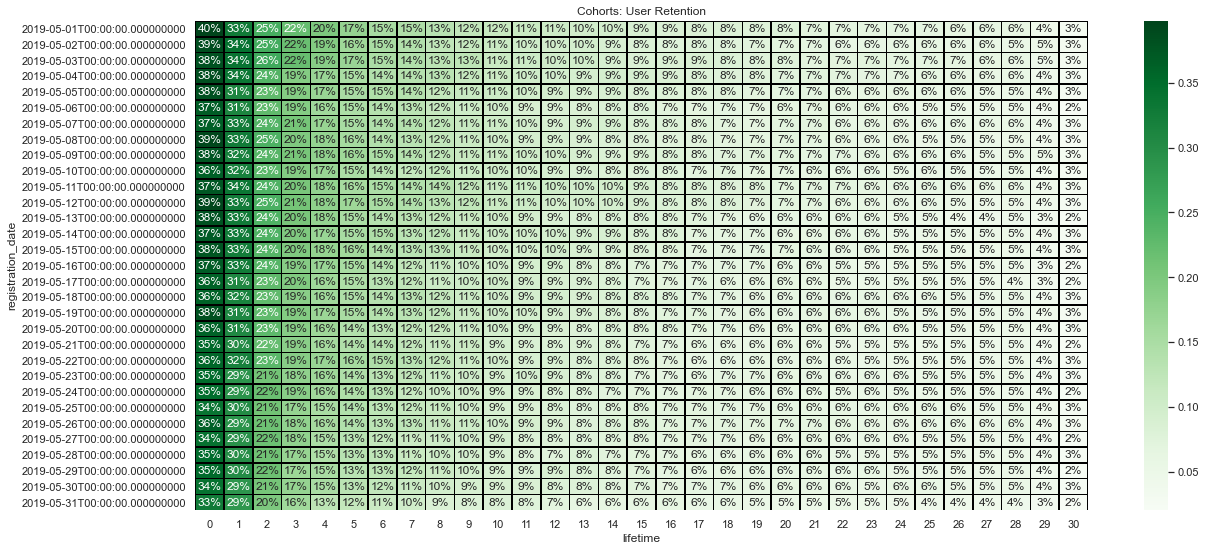

In [16]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set(style='white')
plt.figure(figsize=(20, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, mask=retention_pivot.isnull(), annot=True, fmt='.0%', linewidths=0.5, linecolor='black', cmap="Greens");

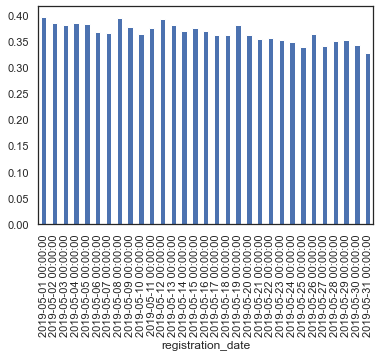

In [17]:
retention_pivot[0].plot.bar()

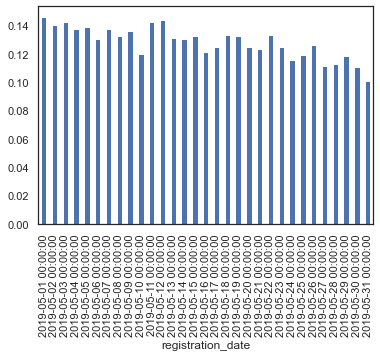

In [18]:
retention_pivot[7].plot.bar()

In [19]:
retention_pivot[7]['2019-05-31']/retention_pivot[7]['2019-05-01']

0.6889460885141001

In [20]:
def getRevenue():
    query = '''SELECT re.date, r.registration_date, count(distinct(re.user_id)) as users_count_with_revenue, sum(re.revenue) as revenue
    FROM case9.user_revenue re
    LEFT JOIN case9.registration r ON r.user_id = re.user_id
    WHERE r.registration_date >= '2019-05-01' and r.registration_date < '2019-06-01'
    GROUP BY 1,2
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

revenue = pd.DataFrame(getRevenue())

In [21]:
revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      912 non-null    object 
 1   registration_date         912 non-null    object 
 2   users_count_with_revenue  912 non-null    int64  
 3   revenue                   912 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 28.6+ KB


In [22]:
for col in ['date','registration_date']:
    revenue[col] = pd.to_datetime(revenue[col])

In [23]:
revenue.head()

,date,registration_date,users_count_with_revenue,revenue
0,2019-05-01,2019-05-01,1672,2357.590
1,2019-05-02,2019-05-01,1420,514.679
2,2019-05-02,2019-05-02,1367,1629.140
3,2019-05-03,2019-05-01,1048,390.952
4,2019-05-03,2019-05-02,1164,533.608


In [24]:
revenue['revenue'].sum()

121998.29795000001

In [25]:
registered_users_count['registered_users_count'].sum()

188943

In [26]:
revenue['revenue'].sum()/registered_users_count['registered_users_count'].sum()

0.6456883713606749

In [27]:
revenue = revenue.rename(columns={'date':'activity_date'})

In [28]:
retention_table_with_revenue = retention_table.merge(revenue,on=['registration_date','activity_date'],how='left')

In [29]:
retention_table_with_revenue.head()

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate,lifetime,users_count_with_revenue,revenue
0,2019-05-01,2019-05-01,2590,6516,0.397483,0,1672.0,2357.590
1,2019-05-02,2019-05-01,2146,6516,0.329343,1,1420.0,514.679
2,2019-05-02,2019-05-02,2049,5309,0.385948,0,1367.0,1629.140
3,2019-05-03,2019-05-01,1637,6516,0.251228,2,1048.0,390.952
4,2019-05-03,2019-05-02,1817,5309,0.342249,1,1164.0,533.608


In [30]:
retention_table_with_revenue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 961 entries, 0 to 960
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   activity_date             961 non-null    datetime64[ns]
 1   registration_date         961 non-null    datetime64[ns]
 2   active_users_count        961 non-null    int64         
 3   registered_users_count    961 non-null    int64         
 4   retention_rate            961 non-null    float64       
 5   lifetime                  961 non-null    int32         
 6   users_count_with_revenue  912 non-null    float64       
 7   revenue                   912 non-null    float64       
dtypes: datetime64[ns](2), float64(3), int32(1), int64(2)
memory usage: 63.8 KB


In [31]:
for col in ['revenue','users_count_with_revenue']:
    retention_table_with_revenue[col] = retention_table_with_revenue[col].fillna(0)

In [32]:
retention_table_with_revenue['users_count_with_revenue'] = retention_table_with_revenue['users_count_with_revenue'].astype(int)

In [33]:
retention_table_with_revenue['arpu'] = retention_table_with_revenue['revenue']/retention_table_with_revenue['users_count_with_revenue']